In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import plotnine as gg
import matplotlib.pyplot as plt
from poola import core as pool
import seaborn as sns
import gpplot
import gpplot as gpp 


In [2]:
def count_elements(seq):
    seqs = {}
    for i in seq:
        seqs[i] = seqs.get(i, 0) + 1
        
    return seqs

In [3]:
evers_data = pd.read_excel('../data/evers_2016/41587_2016_BFnbt3536_MOESM8_ESM.xlsx')

In [4]:
evers_data.Sequence.value_counts()

CCATCATGGTGAGTCTCCCT    1
TCTGTTATTCCTGATGGTTG    1
TCCAGTGGAGCCTTCACGGT    1
AATAAGCATCCGCACCTTTA    1
AGTCCCGCCCCTCGCCGCCG    1
                       ..
CCGCCTCTGGCGGGCCGCAG    1
CATTCTGCAAAGACTTGATG    1
GCTACTTCGCCCGCAGCCCG    1
ACAAAGATCACTTACCCAGG    1
TCGTGGCGTCTTGCTTTTTG    1
Name: Sequence, Length: 683, dtype: int64

In [5]:
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                            names=['GENE'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                   names=['GENE'])

In [7]:
all_designs = pd.read_table('../../../gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3seq-Chen2013_Ensembl_20220808.txt.gz')

# Rep correlation 

In [8]:
lognorms = pool.lognorm_columns(reads_df=evers_data, columns=['t=0 Rep. 1\nRT112',
 't=0 Rep. 2\nRT112',
 't=0 Rep. 3\nRT112',
 't=1 -Dox Rep. 1\nRT112',
 't=1 -Dox Rep. 2\nRT112',
 't=1 -Dox Rep. 3\nRT112',
 't=1 +Dox Rep. 1\nRT112',
 't=1 +Dox Rep. 2\nRT112',
 't=1 +Dox Rep. 3\nRT112'])


In [9]:
lfc_df = pool.calculate_lfcs(lognorms, ref_map = {'t=1 -Dox Rep. 1\nRT112': 't=0 Rep. 1\nRT112'
                                                       , 't=1 -Dox Rep. 2\nRT112': 't=0 Rep. 2\nRT112',
                                                      't=1 -Dox Rep. 3\nRT112': 't=0 Rep. 3\nRT112',
                                                      't=1 +Dox Rep. 1\nRT112': 't=0 Rep. 1\nRT112'
                                                       , 't=1 +Dox Rep. 2\nRT112': 't=0 Rep. 2\nRT112',
                                                      't=1 +Dox Rep. 3\nRT112': 't=0 Rep. 3\nRT112'})

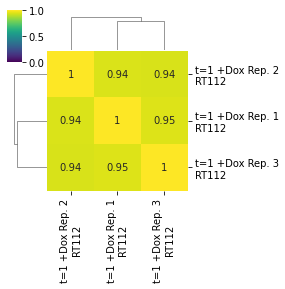

In [10]:
sns.clustermap(lfc_df[[
 't=1 +Dox Rep. 1\nRT112',
 't=1 +Dox Rep. 2\nRT112',
 't=1 +Dox Rep. 3\nRT112']].corr(), vmin= 0, cmap= 'viridis', annot= True, figsize= (4,4))

gpp.savefig('../figure/evers_rep_corr.pdf', dpi=300)

# ROC-AUC

In [11]:
avg_replicate_lfc_df_1 = pool.average_replicate_lfcs(lfcs=lfc_df[['Sequence',
      't=1 -Dox Rep. 1\nRT112',
 't=1 -Dox Rep. 2\nRT112',
 't=1 -Dox Rep. 3\nRT112']], guide_col='Sequence', condition_indices=[0], 
                                              sep=' R')

In [12]:
avg_replicate_lfc_df_2 = pool.average_replicate_lfcs(lfcs=lfc_df[['Sequence',
      't=1 +Dox Rep. 1\nRT112',
 't=1 +Dox Rep. 2\nRT112',
 't=1 +Dox Rep. 3\nRT112']], guide_col='Sequence', condition_indices=[0], 
                                              sep=' R')

In [13]:
avg_replicate_lfc_df = pd.merge(pd.merge(lfc_df[['Sequence', 'Gene']], avg_replicate_lfc_df_1[['Sequence', 'avg_lfc']]
         .rename({'avg_lfc': 'avg_lfc_wo_dox'}, axis=1)), avg_replicate_lfc_df_2[['Sequence', 'avg_lfc', 'n_obs']]
         .rename({'avg_lfc': 'avg_lfc_w_dox'}, axis=1))

In [14]:
design_cols = ['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', "sgRNA 'Cut' Site TSS Offset", 'On-Target Efficacy Score']

In [15]:
lfcs_designs = (avg_replicate_lfc_df.rename({'Sequence': 'sgRNA Sequence'}, axis=1)
                .merge(all_designs[design_cols + ['# Off-Target Tier I Match Bin I Matches']], how='inner',
                       on='sgRNA Sequence'))

In [16]:
lfcs_designs['condition'] = 'RT-112'

In [17]:
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.GENE,
                                fp_genes=nonessential_genes.GENE, gene_col='Target Gene Symbol',
                                score_col='avg_lfc_w_dox', condition_col='condition')
roc_aucs.sort_values('ROC-AUC')

,condition,ROC-AUC
0,RT-112,0.793181


# Compare different normalization techniques
 

In [18]:

relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(essential_genes.GENE)]
filtered_sgs = relevant_sgs_designs[relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
filtered_sgs['gene_mean_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc_w_dox
                                      .transform(lambda x: -(x - x.mean())))
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc_w_dox
                             .rank(pct=True, ascending=False))

filtered_sgs['gene_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc_w_dox
                               .transform(lambda x: -(x - x.mean())/x.std()))
filtered_sgs['gene_median_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc_w_dox
                                        .transform(lambda x: -(x - x.median())))
filtered_sgs['gene_robust_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc_w_dox
                                      .transform(lambda x: -(x - x.median())/(x.quantile(0.75) - x.quantile(0.25))))

sg_avg_rank = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                      'On-Target Efficacy Score'])
               .agg(avg_rank = ('gene_rank', 'mean'),
                    avg_mean_centered_neg_lfc = ('gene_mean_centered', 'mean'),
                    avg_zscore_neg_lfc = ('gene_zscore', 'mean'),
                    avg_median_centered_neg_lfc = ('gene_median_centered', 'mean'),
                    avg_robust_zscore_neg_lfc = ('gene_robust_zscore', 'mean'),
                    avg_lfc = ('avg_lfc_w_dox', 'mean'))
               .reset_index())

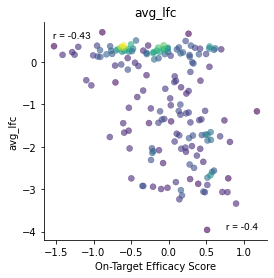

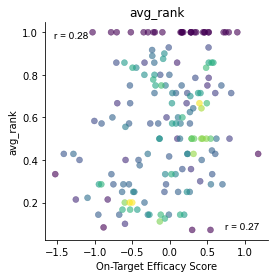

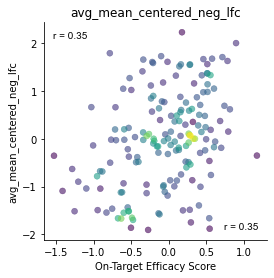

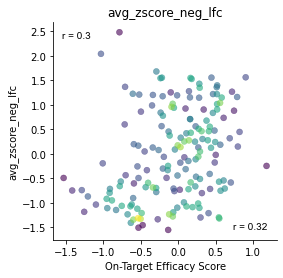

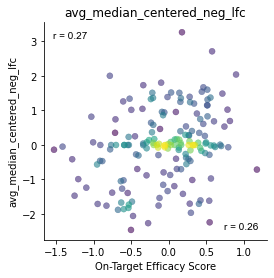

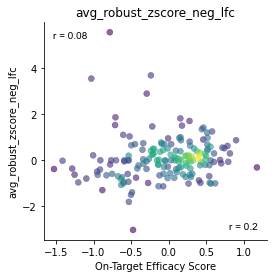

In [17]:
for score in ['avg_lfc','avg_rank', 'avg_mean_centered_neg_lfc', 'avg_zscore_neg_lfc',
              'avg_median_centered_neg_lfc', 'avg_robust_zscore_neg_lfc']:
    plt.subplots(figsize=(4,4))
    gpplot.point_densityplot(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                             y=score, x='On-Target Efficacy Score')
    gpplot.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score')
    gpplot.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score', method='spearman', loc='lower right')
    plt.title(score)
    sns.despine()
    
gpp.savefig('../figure/evers_norm.pdf', dpi=300)

In [18]:
lfcs_designs.to_csv('../data/evers_2016/evers2016_condition_lfcs.csv', index=False)
sg_avg_rank.to_csv('../data/evers_2016/evers2016_activity.csv', index=False)

In [19]:
sg_avg_rank

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,On-Target Efficacy Score,avg_rank,avg_mean_centered_neg_lfc,avg_zscore_neg_lfc,avg_median_centered_neg_lfc,avg_robust_zscore_neg_lfc,avg_lfc
0,AAAGCGGAGCTTCCGGCCGA,AGAGAAAGCGGAGCTTCCGGCCGAGGGCCT,RPL11,0.29700,0.071429,-1.747776,-1.296833,-1.965060,-0.726736,0.388211
1,AACTTGGTTACGACCGGCTG,ACACAACTTGGTTACGACCGGCTGCGGCAG,PSMD6,-0.33900,0.800000,0.133145,0.128809,0.041585,0.040342,-0.672320
2,AAGAAAGGGGCAGCAGCGTC,AAAAAAGAAAGGGGCAGCAGCGTCCGGGTT,RPS11,0.03356,0.714286,0.478902,0.328192,1.521069,0.699307,-1.399546
3,AAGAAGGCGGCTCCCGGAAG,GGAGAAGAAGGCGGCTCCCGGAAGGGGGAG,POLR2A,0.16730,0.600000,0.601782,0.428887,0.000000,0.000000,-2.045866
4,AAGGCGGTCTCAGAGCACCC,GCCGAAGGCGGTCTCAGAGCACCCCGGGTC,PSMA3,1.17600,0.428571,-0.351584,-0.246187,-0.712900,-0.310116,-1.162492
...,...,...,...,...,...,...,...,...,...,...
162,TTGACTGAATCTGACTCCAT,CTTCTTGACTGAATCTGACTCCATTGGAGG,DMRTC2,-0.14010,0.500000,-0.160103,-0.331729,-0.074955,-0.187694,0.339497
163,TTTAGCACGATGAGCTCAAT,TGGGTTTAGCACGATGAGCTCAATCGGCAC,PSMA3,-0.27250,0.142857,-1.904735,-1.333737,-2.266051,-0.985746,0.390659
164,TTTCCTTATCGATTACGCAG,CGGGTTTCCTTATCGATTACGCAGGGGCTG,RPS11,-0.05088,0.285714,-1.108319,-0.759533,-0.066152,-0.030413,0.187675
165,TTTCTTTTGCGGCTCCACGT,GGCGTTTCTTTTGCGGCTCCACGTCGGCAC,COPZ1,-0.12100,0.142857,-1.579032,-1.232383,-1.535186,-0.654280,0.238376
